In [18]:
import os
import sys
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import transforms as T
from PIL import Image
from torch import nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import DataLoader, Dataset

In [4]:
sys.path.append('../')
from utils.dataset import Img_dataset, get_transform

# load image

In [5]:
IMG_DIR = '../input/images/high_2/'

In [6]:
def show_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)    
    
    plt.imshow(img)
    plt.show()


(720, 960, 3)


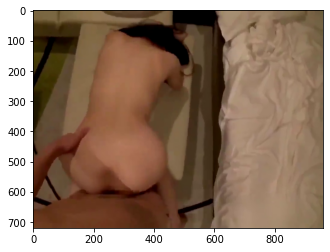

In [7]:
filename = sorted(os.listdir(IMG_DIR))[2000]

show_image(IMG_DIR+filename)

In [21]:
class CFG:
    
    shrink_scale = 16
    xsize = 720
    ysize = 960
    low_xsize = xsize // shrink_scale
    low_ysize = ysize // shrink_scale
    batch_size = 16

In [12]:
class Img_dataset(Dataset):
    def __init__(self, paths, train_tran, val_tran):
        super().__init__()
        self.paths = paths
        self.train_tran = train_tran
        self.val_tran = val_tran
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        file_path = self.paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        return self.train_tran(image=image)['image'], self.val_tran(image=image)['image']

In [13]:
def get_transform(*, TRAIN=False):
    if TRAIN:
        return A.Compose([
            A.Resize(CFG.low_xsize, CFG.low_ysize),
            A.Resize(CFG.xsize, CFG.ysize, interpolation=Image.NEAREST),
            ToTensorV2()
            
        ])
    else:
        return A.Compose([
            ToTensorV2(),
    ])

## データセットの中身を確認

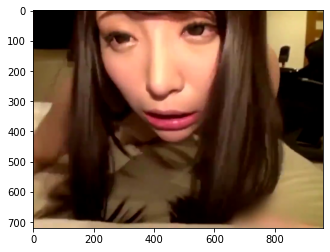

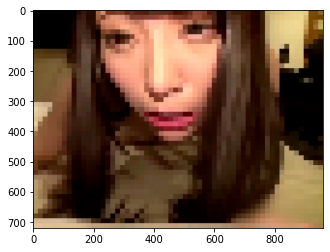

In [14]:
# check dataset
paths = [IMG_DIR+path for path in os.listdir(IMG_DIR)]
train_dataset = Img_dataset(paths, train_tran=get_transform(TRAIN=False),
                            val_tran=get_transform(TRAIN=True))

for i in range(1):
    before = train_dataset[i][0].numpy().astype(int).transpose(1, 2, 0)
    after = train_dataset[i][1].numpy().astype(int).transpose(1, 2, 0)
    
    plt.imshow(before)
    plt.show()
    

    plt.imshow(after)
    plt.show()

In [15]:
len(train_dataset)

4071

In [22]:
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)

## model

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self.conv_bn_relu(1, 32, kernel_size=5) # 32x96x96
        self.enc2 = self.conv_bn_relu(32, 64, kernel_size=3, pool_kernel=4)  # 64x24x24
        self.enc3 = self.conv_bn_relu(64, 128, kernel_size=3, pool_kernel=2)  # 128x12x12
        self.enc4 = self.conv_bn_relu(128, 256, kernel_size=3, pool_kernel=2)  # 256x6x6
        
        self.dec1 = self.conv_bn_relu(256, 128, kernel_size=3, pool_kernel=-2)  # 128x12x12
        self.dec2 = self.conv_bn_relu(128 + 128, 64, kernel_size=3, pool_kernel=-2)  # 64x24x24
        self.dec3 = self.conv_bn_relu(64 + 64, 32, kernel_size=3, pool_kernel=-4)  # 32x96x96
        self.dec4 = nn.Sequential(
            nn.Conv2d(32 + 32, 3, kernel_size=5, padding=2),
            nn.Tanh()
        )

    def conv_bn_relu(self, in_ch, out_ch, kernel_size=3, pool_kernel=None):
        layers = []
        if pool_kernel is not None:
            if pool_kernel > 0:
                layers.append(nn.AvgPool2d(pool_kernel))
            elif pool_kernel < 0:
                layers.append(nn.UpsamplingNearest2d(scale_factor=-pool_kernel))
        layers.append(nn.Conv2d(in_ch, out_ch, kernel_size, padding=(kernel_size - 1) // 2))
        layers.append(nn.BatchNorm2d(out_ch))
        layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        out = self.dec1(x4)
        out = self.dec2(torch.cat([out, x3], dim=1))
        out = self.dec3(torch.cat([out, x2], dim=1))
        out = self.dec4(torch.cat([out, x1], dim=1))
        return out

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_bn_relu(4, 16, kernel_size=5, reps=1) # fake/true color + gray
        self.conv2 = self.conv_bn_relu(16, 32, pool_kernel=4)
        self.conv3 = self.conv_bn_relu(32, 64, pool_kernel=2)
        self.conv4 = self.conv_bn_relu(64, 128, pool_kernel=2)
        self.conv5 = self.conv_bn_relu(128, 256, pool_kernel=2)
        self.out_patch = nn.Conv2d(256, 1, kernel_size=1) #1x3x3

    def conv_bn_relu(self, in_ch, out_ch, kernel_size=3, pool_kernel=None, reps=2):
        layers = []
        for i in range(reps):
            if i == 0 and pool_kernel is not None:
                layers.append(nn.AvgPool2d(pool_kernel))
            layers.append(nn.Conv2d(in_ch if i == 0 else out_ch,
                                    out_ch, kernel_size, padding=(kernel_size - 1) // 2))
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv5(self.conv4(self.conv3(self.conv2(self.conv1(x)))))
        return self.out_patch(out)